In [3]:
!pwd

/content


In [34]:
import sys
from google.colab import drive
drive.mount('/content/drive')
# 將下面路徑取代為你存放此專案的路徑
yourProjectPath = '/content/drive/MyDrive/Class/EdgeAI/FinalPJ/EdgeFinal-main/'
sys.path.append(yourProjectPath)
print(sys.path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/Mydrive/Class/EdgeAI/FinalPJ/EdgeFinal-main', '/content/drive/Mydrive/Class/EdgeAI/FinalPJ/EdgeFinal-main', '/content/drive/MyDrive/Class/EdgeAI/FinalPJ/EdgeFinal-main/', '/content/drive/MyDrive/Class/EdgeAI/FinalPJ/EdgeFinal-main/', '/content/drive/MyDrive/Class/EdgeAI/FinalPJ/EdgeFinal-main/']


In [19]:
# 安裝 EfficientNet 套件
!pip install efficientnet_pytorch
# 取得OpenVINO 2021公開金錀
!wget https://apt.repos.intel.com/openvino/2021/GPG-PUB-KEY-INTEL-OPENVINO-2021 
# 加入OpenVINO公開金錀到系統金錀群中
!apt-key add GPG-PUB-KEY-INTEL-OPENVINO-2021 
# 建立更新安裝清單檔案
!touch /etc/apt/sources.list.d/intel-openvino-2021.list
# 將下載指令加入安裝清單中
!echo "deb https://apt.repos.intel.com/openvino/2021 all main" >> /etc/apt/sources.list.d/intel-openvino-2021.list
# 更新系統
!apt update
# 安裝OpenVINO到虛擬機系統中
!apt install intel-openvino-dev-ubuntu18-2021.3.394
# 列出安裝路徑下內容進行確認
!ls /opt/intel

--2021-06-19 15:51:11--  https://apt.repos.intel.com/openvino/2021/GPG-PUB-KEY-INTEL-OPENVINO-2021
Resolving apt.repos.intel.com (apt.repos.intel.com)... 95.101.204.15, 2a02:26f0:b200:38e::4b23, 2a02:26f0:b200:38d::4b23
Connecting to apt.repos.intel.com (apt.repos.intel.com)|95.101.204.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 939 [binary/octet-stream]
Saving to: ‘GPG-PUB-KEY-INTEL-OPENVINO-2021’

GPG-PUB-KEY-INTEL-O 100%[===================>]     939  --.-KB/s    in 0s      

2021-06-19 15:51:11 (139 MB/s) - ‘GPG-PUB-KEY-INTEL-OPENVINO-2021’ saved [939/939]

OK
Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:5 https://apt.repos.intel.com/openvino/2021 all InRelease [5,647 B]
Hit:6 https://cloud.r-project.org/bin/linux/ubuntu

In [21]:
!pip install openvino

     |████████████████████████████████| 25.4MB 107kB/s 


In [22]:
import torch
import numpy as np
from torch import nn
from torch.nn import Parameter
import math
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os.path as osp
import models
import time
from retina_face import config
from deploy import init_model
from models.efficientNet import MyEfficientNet
from openvino.inference_engine import IENetwork, IECore
from torchvision import transforms, utils
from PIL import Image
import cv2
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [50]:
def inferenceByIR(rgbImg):
    model_xml = yourProjectPath+"model/AFFECTNET_imbalance_10000/FP16/net_011.xml" #指定IR模型檔(*.xml)
    model_bin = yourProjectPath+"model/AFFECTNET_imbalance_10000/FP16/net_011.bin" #指定IR權重檔(*.bin)
    ie = IECore() #建立推論引擎
    # net = cv.dnn.readNetFromModelOptimizer(model_xml, model_bin) # 讀取IR檔

    # read model
    net = IENetwork(model=model_xml, weights=model_bin) #載入模型及權重
    input_blob = next(iter(net.inputs))
    out_blob = next(iter(net.outputs))
    exec_net = ie.load_network(network = net, device_name = "CPU")
    n, c, h, w = net.inputs[input_blob].shape #1, 3, 224, 224
    net.batch_size =1

    # predict
    time_0 = time.clock()
    output = exec_net.infer(inputs={input_blob: rgbImg})[out_blob]
    time_1 = time.clock()
    output = torch.Tensor(output)
    probablity = torch.nn.functional.softmax(output, dim=-1).cpu().detach().numpy().copy()
    score = probablity#np.squeeze(score, 1)
    print("="*60)
    print("[INFO] Probabilities:")
    print(score[0])
    print("="*60)
    print("[INFO] Inference time = {:.4f} sec.".format(time_1 - time_0))
    print("="*60)
    return score

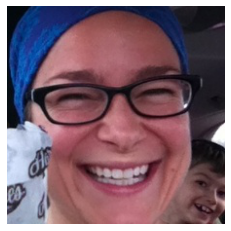

In [46]:
# read data
RGBimg = Image.open(yourProjectPath + 'data/test_img_rgb/test.jpg').convert('RGB').resize((224,224))
transf = transforms.Compose([transforms.ToTensor()])
rgbImg = transf(RGBimg)
unloader = transforms.ToPILImage()
image = unloader(rgbImg)

plt.figure()
plt.axis("off")
plt.imshow(image)

In [51]:
CUDA_VISIBLE_DEVICES=None
# 執行環境設定批次檔並以模型下載器取得模型
!source /opt/intel/openvino_2021/bin/setupvars.sh
probs = inferenceByIR(rgbImg)

[setupvars.sh] OpenVINO environment initialized


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Reading network using constructor is deprecated. Please, use IECore.read_network() method instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: 'inputs' property of IENetwork class is deprecated. To access DataPtrs user need to use 'input_data' property of InputInfoPtr objects which can be accessed by 'input_info' property.
  if __name__ == '__main__':


[INFO] Probabilities:
[0.00261796 0.9371847  0.00452015 0.01329919 0.01058914 0.01111781
 0.01013638 0.01053477]
[INFO] Inference time = 0.0280 sec.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  app.launch_new_instance()


In [43]:
# 對應標籤
AffectName = ['Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Angry', 'Contempt']
emo_idx = np.argmax(probs[0],axis=0)
emo_name = AffectName[emo_idx]

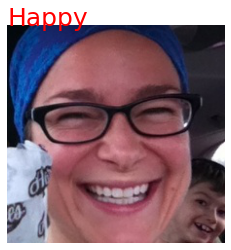

In [44]:
plt.text(0, 0, emo_name, fontsize=25, color="red")
plt.axis("off")
plt.imshow(image)